In [ ]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [ ]:
#|default_exp agents.dqn.target

In [ ]:
#|export
# Python native modules
import os
from collections import deque
from copy import deepcopy
from typing import Callable
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
from torchdata.dataloader2.graph import find_dps,traverse,DataPipe,replace_dp,remove_dp
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *

from fastrl.torch_core import *
# Local modules

from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.vscode_visualizers import *
from fastrl.learner.core import *
from fastrl.agents.dqn.basic import *

# DQN Target
> DQN that uses snapshots from the NN module to stabilize training



## Training DataPipes

In [ ]:
#|export
class TargetModelUpdater(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe=None,target_sync=300):
        self.source_datapipe = source_datapipe
        if source_datapipe is not None:
            self.learner = find_dp(traverse(self),LearnerBase)
            self.learner.target_model = deepcopy(self.learner.model)
        self.target_sync = target_sync
        self.n_batch = 0
        
    def reset(self):
        self.learner = find_dp(traverse(self),LearnerBase)
        self.learner.target_model = deepcopy(self.learner.model)
        
    def __iter__(self):
        if self._snapshot_state.NotStarted: self.reset()
        for batch in self.source_datapipe:
            if self.n_batch%self.target_sync==0:
                self.learner.target_model.load_state_dict(self.learner.model.state_dict())
            self.n_batch+=1
            yield batch

    @classmethod
    def insert_dp(cls,old_dp=ModelLearnCalc,target_sync=300) -> Callable[[DataPipe],DataPipe]:
        def _insert_dp(pipe):
            # v = insert_dp(
            #     traverse(pipe),
            #     find_dp(traverse(pipe),old_dp),
            #     cls(source_datapipe=PassThroughIterPipe(None),target_sync=target_sync)
            # )
            v = replace_dp(
                traverse(pipe,only_datapipe=True),
                find_dp(traverse(pipe,only_datapipe=True),old_dp),
                cls(find_dp(traverse(pipe,only_datapipe=True),old_dp),target_sync=target_sync)
            )
            return list(v.values())[0][0]
        return _insert_dp

In [ ]:
#|export
class TargetModelQCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe=None):
        self.source_datapipe = source_datapipe
        if source_datapipe is not None: self.learner = find_dp(traverse(self),LearnerBase)
        
    def reset(self):
        self.learner = find_dp(traverse(self),LearnerBase)
        
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learner.done_mask = batch.terminated.reshape(-1,)
            with torch.no_grad():
                self.learner.next_q = self.learner.target_model(batch.next_state)
            self.learner.next_q = self.learner.next_q.max(dim=1).values.reshape(-1,1)
            self.learner.next_q[self.learner.done_mask] = 0 
            yield batch
            
    @classmethod
    def replace_dp(cls,old_dp=QCalc) -> Callable[[DataPipe],DataPipe]:
        def _replace_dp(pipe):
            old_dp_instance = find_dp(traverse(pipe),old_dp)
            v = replace_dp(
                traverse(pipe),
                old_dp_instance,
                cls(old_dp_instance.source_datapipe)
            )
            return list(v.values())[0][0]
        return _replace_dp

Try training with basic defaults...

In [ ]:
from fastrl.envs.gym import *

In [ ]:
#|eval:false
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=4000)
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=1,nskips=1,firstlast=False)
)
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=100_000,
                     batches=1000,
                    dp_augmentation_fns=[
                        TargetModelUpdater.insert_dp(),
                        TargetModelQCalc.replace_dp()
                    ]
)
learner.fit(3)
# learner.fit(25)

loss,episode,rolling_reward,epoch,batch,epsilon
0.013058196,52,19.588235,1,1001,0.749500
0.0881805,96,20.936842,2,1001,0.499250
0.26291308,116,25.860000,2,1001,0.249250


The DQN learners, but I wonder if we can get it to learn faster...

In [ ]:
#|eval:false
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=10000)
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True), # We basically merge 2 steps into 1 and skip. 
    (GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,n=100,include_images=True),VSCodeTransformBlock())
)
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=20_000,nsteps=2,lr=0.001,
                     batches=1000,
                    dp_augmentation_fns=[
                        TargetModelUpdater.insert_dp(),
                        TargetModelQCalc.replace_dp()
                    ])
learner.fit(3)
# learner.fit(10)

loss,episode,rolling_reward,epoch,batch,epsilon
0.0866633,70,29.300000,1,1001,0.810300
1.1521769,114,44.820000,2,1001,0.616700
1.852667,134,67.080000,2,1001,0.419800


Creating gif from 300 frames


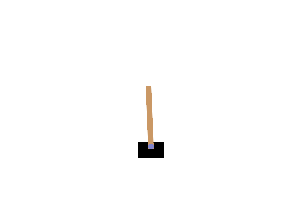

In [ ]:
#|hide
#|eval:false
learner.validate(3)

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()